# Neural Bandit

Implementing neural bandit using scikit-learn's multilayer perceptron.

In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np

In [2]:
USER_LIKED_ARTICLE = 1.0
USER_DISLIKED_ARTICLE = 0.0

In [3]:
def get_cost(context, action):
    match (context["user"], context["time_of_day"], action):
        case ("Tom", "morning", "politics"):
            return USER_LIKED_ARTICLE
        case ("Tom", "afternoon", "music"):
            return USER_LIKED_ARTICLE
        case ("Anna", "morning", "sports"):
            return USER_LIKED_ARTICLE
        case ("Anna", "afternoon", "politics"):
            return USER_LIKED_ARTICLE
        case _:
            return USER_DISLIKED_ARTICLE

In [4]:
users = ["Tom", "Anna"]
times_of_day = ["morning", "afternoon"]
actions = ["politics", "sports", "music", "food", "finance", "health", "camping"]


def one_hot_encode(user, time_of_day, action):
    return [users.index(user) + 1, times_of_day.index(time_of_day) + 1] + [
        1 if a == action else 0 for a in actions
    ]


one_hot_encode("Tom", "morning", "politics")

[1, 1, 1, 0, 0, 0, 0, 0, 0]

In [5]:
from sklearn.feature_extraction import FeatureHasher

hasher = FeatureHasher(n_features=10, input_type="string")
print(hasher.transform([["a", "b", "c"]]).toarray())
print(hasher.transform([["c", "a", "b"]]).toarray())

[[ 1. -1.  0.  0.  0.  0.  0. -1.  0.  0.]]
[[ 1. -1.  0.  0.  0.  0.  0. -1.  0.  0.]]


In [6]:
from itertools import combinations_with_replacement

# This is similar to how vowpal wabbit does the feature interaction.
print(list(combinations_with_replacement("abc", 2)))
print(list(combinations_with_replacement(["Tom", "politics"], 2)))

[('a', 'a'), ('a', 'b'), ('a', 'c'), ('b', 'b'), ('b', 'c'), ('c', 'c')]
[('Tom', 'Tom'), ('Tom', 'politics'), ('politics', 'politics')]


In [7]:
# https://github.com/VowpalWabbit/vowpal_wabbit/wiki/Feature-interactions
# https://vowpalwabbit.org/docs/vowpal_wabbit/python/latest/tutorials/python_Simulating_a_news_personalization_scenario_using_Contextual_Bandits.html#:~:text=supply%20to%20VW-,%2C%20we%20include%20%2Dq%20UA,-.%20This%20is%20telling
def feature_interaction(user, time_of_day, action):
    """perform feature interactions, similar to how vowpal wabbit does it.
    We create additional features which are the features in the (U)ser namespace and (A)ction
    namespaces multiplied together.
    This allows us to learn the interaction between when certain actions are good in certain times of days and for particular users.
    If we didn’t do that, the learning wouldn’t really work.
    We can see that in action below.
    """
    features = [
        user,
        time_of_day,
        user + ":" + action,
        time_of_day + ":" + action,
        action,
    ]
    return hasher.transform([features]).toarray()[0]

In [8]:
feature_interaction("Tom", "morning", "politics")

array([ 0.,  0., -1.,  1.,  0.,  0.,  2.,  0.,  1.,  0.])

In [56]:
import numpy as np


def softmax(lst, tau=1.0):
    lst = np.array(lst) / tau
    exps = np.exp(lst)
    return exps / np.sum(exps)

In [57]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(activation="relu", random_state=42)
model.partial_fit([one_hot_encode("Tom", "morning", "politics")], [1])
model.predict([one_hot_encode("Tom", "morning", "politics")])

array([0.20727216])

In [58]:
# Sampling best reward for the action taken.
rewards = model.predict(
    [one_hot_encode("Tom", "morning", action) for action in actions]
)
p = softmax(rewards)
action = np.random.choice(actions, p=p)
rewards, p, action

(array([ 0.20727216,  0.11697445,  0.33291172,  0.24473987,  0.35555384,
         0.13795523, -0.00638099]),
 array([0.14313913, 0.13078037, 0.16230165, 0.14860396, 0.16601842,
        0.13355323, 0.11560323]),
 'camping')

In [59]:
model = MLPRegressor(activation="relu", random_state=42)
model.partial_fit([feature_interaction("Tom", "morning", "politics")], [1])
model.predict([feature_interaction("Tom", "morning", "politics")])

array([0.30681819])

In [62]:
# Sampling best reward for the action taken.
rewards = model.predict(
    [feature_interaction("Tom", "morning", action) for action in actions]
)
p = softmax(rewards)
action = np.random.choice(actions, p=p)
rewards, p, action

(array([0.30681819, 0.82605623, 0.57201208, 0.39640068, 0.28572226,
        0.5167437 , 0.44741572]),
 array([0.11845786, 0.19909764, 0.15443159, 0.12955945, 0.11598506,
        0.14612798, 0.13634042]),
 'finance')

In [63]:
p = softmax(rewards, tau=0.2)
action = np.random.choice(actions, p=p)
rewards, p, softmax(rewards), action

(array([0.30681819, 0.82605623, 0.57201208, 0.39640068, 0.28572226,
        0.5167437 , 0.44741572]),
 array([0.03918545, 0.5255765 , 0.14756592, 0.06132687, 0.0352627 ,
        0.11193665, 0.07914592]),
 array([0.11845786, 0.19909764, 0.15443159, 0.12955945, 0.11598506,
        0.14612798, 0.13634042]),
 'sports')

In [65]:
def choose_user(users):
    return random.choice(users)


def choose_time_of_day(times_of_day):
    return random.choice(times_of_day)


def get_action(model, context, actions, preprocess):
    rewards = model.predict(
        [
            preprocess(context["user"], context["time_of_day"], action)
            for action in actions
        ]
    )
    action = np.random.choice(actions, p=softmax(rewards, tau=0.2))
    return action

In [66]:
def run_simulation(
    model,
    num_iterations,
    users,
    times_of_day,
    actions,
    cost_function,
    do_learn=True,
    preprocess=one_hot_encode,
):
    cost_sum = 0.0
    ctr = []

    for i in range(1, num_iterations + 1):
        # 1. In each simulation choose a user
        user = choose_user(users)
        # 2. Choose time of day for a given user
        time_of_day = choose_time_of_day(times_of_day)

        # 3. Pass context to vw to get an action
        context = {"user": user, "time_of_day": time_of_day}
        action = get_action(model, context, actions, preprocess)

        # 4. Get cost of the action we chose
        cost = cost_function(context, action)
        cost_sum += cost

        if do_learn:
            # 5. Learn
            model.partial_fit([preprocess(user, time_of_day, action)], [cost])

        # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
        ctr.append(1 * cost_sum / i)

    return ctr

In [67]:
def plot_ctr(num_iterations, ctr):
    plt.plot(range(1, num_iterations + 1), ctr)
    plt.xlabel("num_iterations", fontsize=14)
    plt.ylabel("ctr", fontsize=14)
    plt.ylim([0, 1])

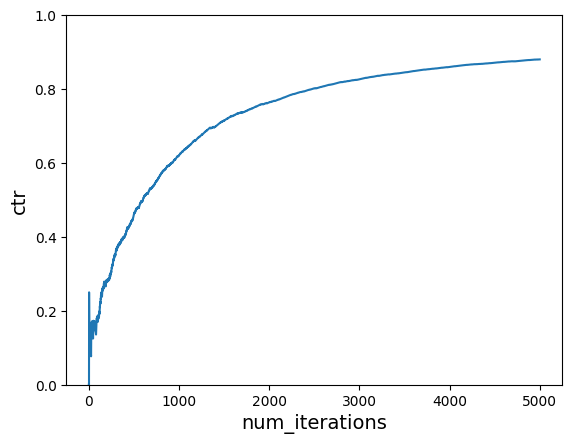

In [68]:
num_iterations = 5000
# Need to fit at least once.
model = MLPRegressor(random_state=42)
model.partial_fit([one_hot_encode("Tom", "morning", "politics")], [1])
ctr = run_simulation(model, num_iterations, users, times_of_day, actions, get_cost)
old_ctr = ctr
plot_ctr(num_iterations, ctr)

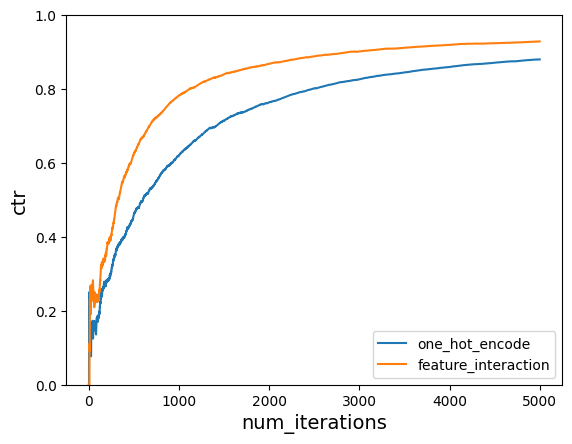

In [69]:
num_iterations = 5000
# Need to fit at least once.
model = MLPRegressor(activation="relu", random_state=42)
model.partial_fit([feature_interaction("Tom", "morning", "politics")], [1])
ctr = run_simulation(
    model,
    num_iterations,
    users,
    times_of_day,
    actions,
    get_cost,
    preprocess=feature_interaction,
)

plt.plot(range(1, num_iterations + 1), old_ctr)
plot_ctr(num_iterations, ctr)
plt.legend(["one_hot_encode", "feature_interaction"])

In [70]:
context = {"user": "Anna", "time_of_day": "morning"}
get_action(model, context, actions, feature_interaction)

'sports'

In [71]:
context = {"user": "Anna", "time_of_day": "afternoon"}
get_action(model, context, actions, feature_interaction)

'politics'

In [72]:
def get_cost_new1(context, action):
    match (context["user"], context["time_of_day"], action):
        case ("Tom", "morning", "politics"):
            return USER_LIKED_ARTICLE
        case ("Tom", "afternoon", "sports"):
            return USER_LIKED_ARTICLE
        case ("Anna", "morning", "sports"):
            return USER_LIKED_ARTICLE
        case ("Anna", "afternoon", "sports"):
            return USER_LIKED_ARTICLE
        case _:
            return USER_DISLIKED_ARTICLE

In [73]:
def run_simulation_multiple_cost_functions(
    model,
    num_iterations,
    users,
    times_of_day,
    actions,
    cost_functions,
    do_learn=True,
    preprocess=feature_interaction,
):
    cost_sum = 0.0
    ctr = []

    start_counter = 1
    end_counter = start_counter + num_iterations
    for cost_function in cost_functions:
        for i in range(start_counter, end_counter):
            # 1. in each simulation choose a user
            user = choose_user(users)
            # 2. choose time of day for a given user
            time_of_day = choose_time_of_day(times_of_day)

            # Construct context based on chosen user and time of day
            context = {"user": user, "time_of_day": time_of_day}

            # 3. Use the get_action function we defined earlier
            action = get_action(model, context, actions, preprocess)

            # 4. Get cost of the action we chose
            cost = cost_function(context, action)
            cost_sum += cost

            if do_learn:
                # 5. Inform VW of what happened so we can learn from it
                model.partial_fit([preprocess(user, time_of_day, action)], [cost])

            ctr.append(1 * cost_sum / i)
        start_counter = end_counter
        end_counter = start_counter + num_iterations

    return ctr

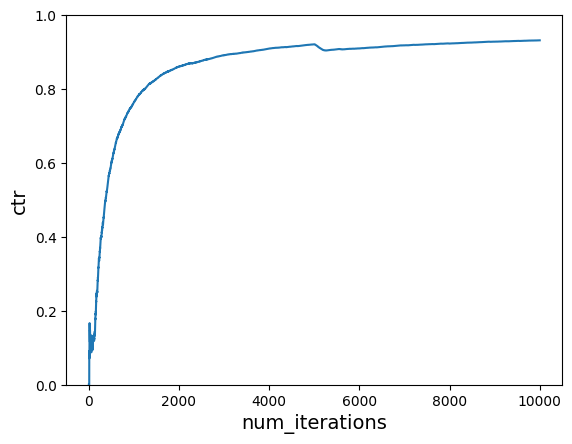

In [74]:
model = MLPRegressor(activation="relu", random_state=42)
cost_functions = [get_cost, get_cost_new1]
num_iterations_per_cost_func = 5000
total_iterations = num_iterations_per_cost_func * len(cost_functions)

# Need to fit at least one data before using.\n",
model.partial_fit([feature_interaction("Tom", "morning", "politics")], [1])
ctr = run_simulation_multiple_cost_functions(
    model,
    num_iterations_per_cost_func,
    users,
    times_of_day,
    actions,
    cost_functions,
    preprocess=feature_interaction,
)
plot_ctr(total_iterations, ctr)